# Lab Part 4
# Neural Network Model Template

#
#



## Part 1: Unpack our data
All we do is install 7zip and then use pyunpack to extract the files 

In [ ]:
# unzip the data

#install dependencies
!apt-get update
!apt-get install -y p7zip-full
!pip install pyunpack
!pip install patool

from pyunpack import Archive
Archive('data.7z').extractall("/notebooks")

## Part 2: Define where we store our data
This is pretty simple our folder structure looks like this
- data/
    - train/
    - test/

So we simply create 2 variables to store these locations

In [9]:
data_dir = 'data/' # change this to your data directory
train_dir = data_dir + 'train/' # directory for training images
test_dir = data_dir + 'test/' # directory for test images we use the test images to make sure our model is working well

## Part 3: Loading in the data
### Dealing with images
Our image files that we are using for training are pretty large. Your computer may crash if we loaded them all at once so instead we will just store where the images are stored. Later you will see how we can automatically load these files when we run our code. One thing to note is that each image file is named (somenumber).jpg that number is the number of milliseconds since 1 January 1970 (Unix Time) when the file was recorded. This means that we will never have any overlapping files. Unfortunately this does mean we will have to sort the times from smallest to largest to make sure that they correspond with the steering angles.

### Dealing with steering angles
We store our steering values as a csv (comma separated values) file. Python has a built in csv module so we can easily use it to load in all the steering values into a list. These don't take up much ram so it doesn't matter if we load them all in at once.

### Making sure the files line up
Since we sort our images, and the csv file is read in line by line the files will line up with their correct steering angles. It looks something like this. If we mess this up then the data being fed into your network would be totally incoherent. Garbage in Garbage out.

train_img =   | image 1    | image 2    | image 3    | image 4    | image 5    |...

train_steer = | steering 1 | steering 2 | steering 3 | steering 4 | steering 5 |...

In [10]:
import csv
import os
# lets make a function that loads the images and labels
def load_data(directory):
    image__paths = []
    csv_file = ""
    for file in os.listdir(directory): # for each file in the directory
        if file.endswith(".jpg"): # if the file is an image
            image__paths.append(directory + file) # add the image path to the list
        if file.endswith(".csv"): # if the file is a csv file
            csv_file = file # we save it for later

    # now our files are in the train list we need to sort them from smallest file name to largest. The file name is the exact time the image was taken.
    image__paths.sort(key=lambda x: int(x.split('/')[-1][:-4])) # the lambda function returns the numbers in the file name

    # now we need to read the csv file and get the steering angles
    with open(directory + csv_file, 'r') as f:
        reader = csv.reader(f) # create a reader object
        steering_angles = [] # create a list to store the steering angles
        for row in reader: # for each row in the csv file
            steering_angles.append(float(row[0])) # add the steering angle to the list
    return image__paths, steering_angles # return the image paths and steering angles

In [4]:
train_img, train_steer = load_data(train_dir) # load the training data
test_img, test_steer = load_data(test_dir) # load the test data

## Part 4: Loading the images on the fly

Now we create a data generator that automatically fetches the images when we need it.
This generator will also apply our image processing that we learnt about in our last lab.
This generator takes in a batch_size which means we can increase or decrease the amount of data returned based on how much RAM our computer has.

In [11]:
import numpy as np
import cv2 as cv

def batch_generator(image_paths, steering_angles, batch_size):
    while True:
        for start in range(0, len(image_paths), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(image_paths))
            ids_batch = image_paths[start:end]
            for id in ids_batch:
                img = cv.imread(id)
                img = cv.resize(img, (100, 66))
                # we convert the frame to the HSV color space
                hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
                # blur the image to remove noise
                blur = cv.GaussianBlur(hsv, (5, 5), 0)
                # mask the image to get only the desired colors
                mask = cv.inRange(blur, (40, 25, 73), (93, 194, 245))
                # we erode and dilate to remove noise
                erode = cv.erode(mask, np.ones((5, 5), np.uint8), iterations=1)
                dilate = cv.dilate(erode, np.ones((5, 5), np.uint8), iterations=1)
                # we smooth the image with some gaussian blur
                blur = cv.GaussianBlur(dilate, (5, 5), 0)
                x_batch.append(blur)
                y_batch.append(steering_angles[image_paths.index(id)])
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)
            yield x_batch, y_batch


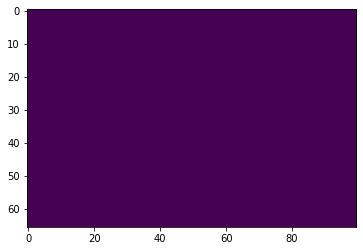

In [12]:
# display the first image and steering angle
import matplotlib.pyplot as plt
x_batch, y_batch = next(batch_generator(train_img, train_steer, 500))
plt.imshow(x_batch[145])

## Part 5: This is where you will create your model
try modifying the layers to try to get the lowest mse score,
This is going to require some trial and error so make sure you spend some time experimenting.

In [7]:
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, InputLayer

# a sequential model is a model that is made up of layers
model = Sequential()
# the input layer is the first layer in the model
model.add(InputLayer(input_shape=(100, 66, 1)))

# try modifying the number of nodes in the hidden layer to see how it affects the model
# you can also try changing the activation function to see how it affects the model
# adding more layers to the model may also help
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1 ,activation='linear'))

batch_size = 32 # increase this if you have a lot of memory
train_gen = batch_generator(train_img, train_steer, batch_size)
test_gen = batch_generator(test_img, test_steer, batch_size)


model.compile(optimizer='adam', loss='mse', metrics=["mse"]) # we will keep track of the mean squared error using mse
hist = model.fit(train_gen, steps_per_epoch=np.ceil(float(len(train_img)) / float(batch_size)), validation_data=test_gen, validation_steps=25, epochs=25) # changing the number of epochs may help the model!

Epoch 1/25
5/5 [==============================] - 4s 769ms/step - loss: 8215.7061 - mse: 8215.7070 - val_loss: 8214.7012 - val_mse: 8214.7002
Epoch 2/25
5/5 [==============================] - 2s 610ms/step - loss: 8213.8740 - mse: 8213.8730 - val_loss: 8212.7441 - val_mse: 8212.7451
Epoch 3/25
5/5 [==============================] - 2s 617ms/step - loss: 8211.8750 - mse: 8211.8750 - val_loss: 8210.6758 - val_mse: 8210.6768
Epoch 4/25
5/5 [==============================] - 2s 612ms/step - loss: 8209.7471 - mse: 8209.7461 - val_loss: 8208.4707 - val_mse: 8208.4707
Epoch 5/25
5/5 [==============================] - 2s 601ms/step - loss: 8207.4980 - mse: 8207.4990 - val_loss: 8206.1592 - val_mse: 8206.1602
Epoch 6/25
5/5 [==============================] - 2s 612ms/step - loss: 8205.1514 - mse: 8205.1514 - val_loss: 8203.7539 - val_mse: 8203.7520
Epoch 7/25
5/5 [==============================] - 3s 626ms/step - loss: 8202.7041 - mse: 8202.7051 - val_loss: 8201.2402 - val_mse: 8201.2412
Epoch 

Have a look at the graph generated below. With this you can get an idea of whether your model is training well. You should want to see both lines trend downwards.

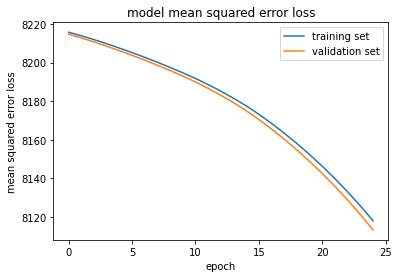

In [8]:
import matplotlib.pyplot as plt

# lets plot the model's history
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


## Part 6: export your model
Once you are happy with your model you can export it by running the code below.
This will save your model as model.h5. You can change this to be more descriptive. I also recommend saving multiple models with different training settings so you have a couple to experiment with. 

In [40]:
model.save('model.h5') # save the model change the name to something more descriptive if you want